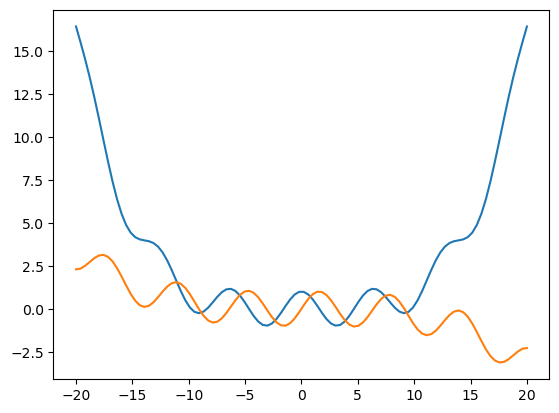

In [47]:
import propagators
import energy_landscapes
import long_simulation
import weighted_ensemble_2
import numpy as np
import MSM_methods
import analysis

import matplotlib.pyplot as plt
import importlib

#methods for fast print debugging
def p(x):
    print(x)
def pl(x):
    print(len(x))
def ps(x):
    print(x.shape)

kT = 1
dt = 0.001
n_analysis_bins = 50
save_period = 100 #in steps
aggregate_simulation_limit = 100000000
#nsteps = 100000
n_parallel = 1000
n_bootstrap = 3

system1 = energy_landscapes.unit_sine_well()
system1.plot_quantity(system1.potential)
system1.plot_quantity(system1.F)
#system1.analysis_bins(40)


<function long_simulation_histogram_analysis at 0x7fd60316d7e0>
round 0
round 1
round 2
<function long_simulation_hamsm_analysis at 0x7fd60316cc10>
round 0
eigenvector converged to within 10^-12 after 0 rounds
round 1
eigenvector converged to within 10^-12 after 1 rounds
round 2
eigenvector converged to within 10^-12 after 1 rounds
<function weighted_ensemble_hamsm_analysis at 0x7fd60316cf70>
round 0
Each bin can hold up to 20 walkers, for a total of up to 1040 walkers
0
100
200
300
400
500
600
700
800
900
eigenvector converged to within 10^-12 after 24 rounds
round 1
Each bin can hold up to 20 walkers, for a total of up to 1040 walkers
0
100
200
300
400
500
600
700
800
900
eigenvector converged to within 10^-12 after 25 rounds
round 2
Each bin can hold up to 20 walkers, for a total of up to 1040 walkers
0
100
200
300
400
500
600
700
800
900
eigenvector converged to within 10^-12 after 26 rounds


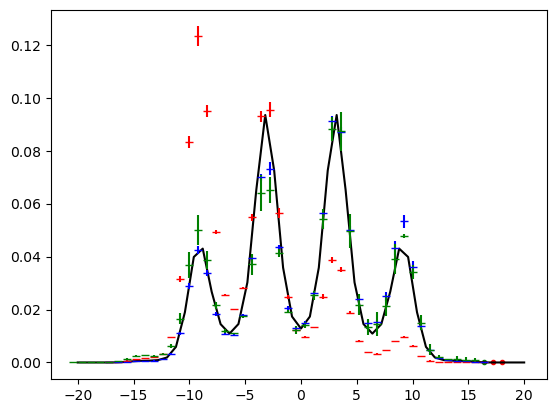

In [48]:
importlib.reload(analysis)
importlib.reload(long_simulation)
importlib.reload(weighted_ensemble_2)

mfpts_all, populations_all = analysis.bootstrap_method_comparison(3, [long_simulation.long_simulation_histogram_analysis, long_simulation.long_simulation_hamsm_analysis, weighted_ensemble_2.weighted_ensemble_hamsm_analysis], system1, kT, dt, aggregate_simulation_limit, n_parallel, save_period, n_analysis_bins)

analysis.plot_bootstrapping_results(populations_all, system1, kT, n_analysis_bins)

In [ ]:
importlib.reload(MSM_methods)
importlib.reload(long_simulation)

mfpts_long_raw = []
mfpts_long_hamsm = []

for bs in range(n_bootstrap):

    print(bs)

    x_init_coord = system1.standard_init_coord
    nsteps = 100000
    n_parallel = 1000
    lag_time = 1

    long_trjs = long_simulation.run_long_parallel_simulations(propagators.propagate, system1, kT, dt, nsteps, save_period, n_parallel)
    print(f"simulation steps:\n Aggregate: {nsteps*n_parallel} \n Molecular: {nsteps}")


    #------------------------------------------------------------------------------------------
    #non-MSM analysis
    x, p = long_simulation.estimate_eq_pops_histogram(long_trjs, system1, nbins)
    transitions, mfpts = long_simulation.calc_mfpt(system1.macro_class, system1.n_macrostates, save_period, long_trjs)
    if n_bootstrap == 1:
        metrics = analysis.landscape_comparison(system1, kT, x, p, metrics = ["maew"])
        analysis.print_mfpts_2states(mfpts)

    inter_well_mpfts = [mfpts[0,1], mfpts[1,0]]
    mfpts_long_raw.append(np.mean(inter_well_mpfts))


    #------------------------------------------------------------------------------------------
    #MSM analysis
    # x_msm, eqp_msm, mfpts_msm = long_simulation.msm_analysis(long_trjs, nbins, system1.macro_class, system1.n_macrostates(), save_period, lag_time=lag_time, show_TPM=False)
    # metrics = analysis.landscape_comparison(system1, kT, x_msm, eqp_msm, metrics = ["maew"])

    # analysis.print_mfpts_2states(mfpts_msm)


    #TODO as a more stringent test break this into two cells: 
    # In the first calculate MFPTs from a single long trajectory by brute force, 
    # and in the second calculate them from many very short (too short to get accurate brute force results) ones with an MSM.
    # if you build an MSM from trajectories so long the system has equilibrated by brute force you could get accurate MFPTs even if there's something wrong with MSM construction
    #------------------------------------------------------------------------------------------
    #haMSM analysis
    #note that lag time is measured in saved frames
    ha_transitions = long_simulation.get_ha_transitions(long_trjs, nbins, system1, lag_time=1)
    x_hamsm, eqp_hamsm, x_ens, p_ens, mfpts_hamsm = analysis.hamsm_analysis(ha_transitions, nbins, system1, save_period, lag_time=1, show_TPM=False)
    #long_simulation.hamsm_analysis(long_trjs, nbins, system1, save_period, lag_time=1, show_TPM=False)
    if n_bootstrap == 1:
        metrics = analysis.landscape_comparison(system1, kT, x_hamsm, eqp_hamsm, metrics = ["maew"], ensemble_data = [x_ens, p_ens])
        analysis.print_mfpts_2states(mfpts_hamsm)

    inter_well_mpfts_hamsm = [mfpts_hamsm[0,1], mfpts_hamsm[1,0]]
    mfpts_long_hamsm.append(np.mean(inter_well_mpfts_hamsm))

plt.hist(mfpts_long_raw, alpha=0.5)
plt.hist(mfpts_long_hamsm, alpha=0.5)


# WE simulation

In [ ]:

mfpts_we_hamsm = []

for bs in range(n_bootstrap):
    #Weighted ensemble (WE) parameters and inputs

    N = 500             #total number of walkers within binrange
    #nbins = 40         #total number of bins within binrange 
    #nbins should match the value above, at least for analysis; make a separate n_bins_analysis variable

    walkers_per_bin = round(N/nbins)
    print(f"Each bin can hold up to {walkers_per_bin} walkers, for a total of up to {walkers_per_bin*(nbins+2)} walkers")

    binrange = system1.standard_analysis_range 

    #progress coordinate range within which to bin simulations
                        #this should extend well past the stall point for examination of the WE stall force
                        #the area past either end of binrange is a bin extending to either + or - inf, yielding a total of nbins+2 bins
    n_macrostates=2
            
    nsteps = save_period        #round length; to match long simulations since MFPT = f(lag time)
    nrounds = 4000              #number of WE rounds to run

    x_init_val = system1.standard_init_coord

    #run weighted ensemble with brownian dynamics
    #put this on multiple lines
    x_init, e_init, w_init, binbounds, xtrj, etrj, wtrj, transitions, hamsm_transitions, n_trans_by_round \
    = weighted_ensemble_2.weighted_ensemble_start(\
                        x_init_val,\
                        nrounds,\
                        nbins,\
                        walkers_per_bin,\
                        binrange, propagators.propagate_save1,\
                        [system1, kT, dt, nsteps],\
                        system1.ensemble_class,\
                        n_macrostates,\
                        ha_binning=False)


    aggregate_walkers = len([j for i in xtrj for j in i])
    print(f"simulation steps:\n Aggregate: {nsteps*aggregate_walkers} \n Molecular: {nsteps*nrounds}")

    
    #x, p, xs, es = weighted_ensemble_2.landscape_recovery(xtrj, wtrj, binbounds, transitions, hamsm_transitions, n_trans_by_round, nrounds, n_macrostates, system1.potential, system1.macro_class, kT)

    x_hamsm, eqp_hamsm, x_ens, p_ens, mfpts_hamsm = analysis.hamsm_analysis(hamsm_transitions, nbins, system1, nsteps, lag_time=1, show_TPM=False)

    if n_bootstrap == 1:
        metrics = analysis.landscape_comparison(system1, kT, x_hamsm, eqp_hamsm, metrics = ["maew"], ensemble_data = [x_ens, p_ens])
        analysis.print_mfpts_2states(mfpts_hamsm)

    inter_well_mpfts_we_hamsm = [mfpts_hamsm[0,1], mfpts_hamsm[1,0]]
    mfpts_we_hamsm.append(np.mean(inter_well_mpfts_we_hamsm))


plt.hist(mfpts_long_raw, alpha=0.5)
plt.hist(mfpts_long_hamsm, alpha=0.5)
plt.hist(mfpts_we_hamsm, alpha=0.5)


In [ ]:
#plotting

def plot_synthetic_landscapes(xi_all, pi_all, e_all, pi_all_out, box_min, box_max, minima_coords, plot_p=False, plot_e=False, plot_e_out=False, plot_hist=False, plot_states=False):
    
    if plot_p:
        if plot_hist:
            plt.hist2d([i[0] for i in xi_all], [i[1] for i in xi_all], weights = pi_all, bins = [40,40], range=[[box_min[0],box_max[0]],[box_min[1],box_max[1]]])
            for mc in minima_coords:
                plt.scatter(mc[0], mc[1])
            plt.axis("equal")
            plt.show()

        if plot_states:
            plt.scatter([i[0] for i in xi_all], [i[1] for i in xi_all], c=pi_all, cmap='viridis')
            plt.axis("equal")
            plt.show()

    if plot_e:
        #histograms of energies are a bad idea because adding positive energies makes the state appear higher in energy when it is actually lower
        # if plot_hist:
        #     plt.hist2d([i[0] for i in xi_all], [i[1] for i in xi_all], weights = e_all, bins = [40,40], range=[[box_min[0],box_max[0]],[box_min[1],box_max[1]]])
        #     for mc in minima_coords:
        #         plt.scatter(mc[0], mc[1])
        #     plt.axis("equal")
        #     plt.show()

        if plot_states:
            plt.scatter([i[0] for i in xi_all], [i[1] for i in xi_all], c=e_all, cmap='viridis')
            plt.axis("equal")
            plt.show()
    
    if plot_e_out:
        if plot_hist:
            plt.hist2d([i[0] for i in xi_all], [i[1] for i in xi_all], weights = pi_all_out, bins = [40,40], range=[[box_min[0],box_max[0]],[box_min[1],box_max[1]]])
            for mc in minima_coords:
                plt.scatter(mc[0], mc[1])
            plt.axis("equal")
            plt.show()

        if plot_states:
            plt.scatter([i[0] for i in xi_all], [i[1] for i in xi_all], c=pi_all_out, cmap='viridis')
            plt.axis("equal")
            plt.show()

In [ ]:

#build an energy landscape with a specified set of minima, and transition states.
        #this landscape is to be represented by a set of points placed randomly in n-dimensional space at the specified state_density
        #temperature is used to construct the transition probability matrix (it should cancel out elsewhere? <--TODO verify this)
        #noise spectrum is the amplitude of noise to apply as a function of the spatial frequency of the noise (i.e. a low frequency noise is applied with wide gaussians)
def build_landscape(n_dim, minima_coords, minima_energies, state_density, kT, threshold, min_spacing, noise_spectrum):

    #select box dimensions that will include the whole of the relevant landscape
    mc_max = []
    mc_min = []

    #find dimensions that will extend 3 standard deviations from the bottom of each well
    for mci, mei in zip(minima_coords, minima_energies):
        mc_min.append([mcij-3*mei[1] for mcij in mci])
        mc_max.append([mcij+3*mei[1] for mcij in mci])

    box_min = np.min(mc_min, axis=0)
    box_max = np.max(mc_max, axis=0)

    box_lengths = box_max-box_min
    box_vol = np.prod(box_lengths)

    #obtain initial population estimates using the minima provided
    pi_all = []
    xi_all = []

    for point in range(state_density*box_vol):
        #sample uniformly distributed random coordinates within the box
        xi = np.multiply(box_lengths, np.random.rand(n_dim)) + box_min
        
        #keep only coordinates that are sufficiently far from existing ones since a more uniform distribution is a more efficient representation of configuration space
        #note that this creates surfaces slightly denser than the interior of the populated regions because there are no neighbors on one side which could be below the spacing threshold
        #but avoiding this would be expensive and it probably doesn't matter
        if len(xi_all) > 0:
            #print(np.stack(xi_all))
            #print(np.stack([xi for l in range(len(xi_all))], axis=0))
            dists_to_existing = np.linalg.norm(np.stack([xi for l in range(len(xi_all))], axis=0) - np.stack(xi_all), axis=1)
            if np.min(dists_to_existing) < min_spacing:
                point -= 1
                continue

        #count up total probability at current coordinates from all of the harmonic wells provided as arguments
        pi = 0
        for mc, me in zip(minima_coords, minima_energies):
            pi += np.exp(-(me[0] + (np.linalg.norm(mc-xi) / me[1]**(1/n_dim))**2))

        #discard nearly empty wells to save time
        if pi >= threshold:
            xi_all.append(xi)
            pi_all.append(pi)

    #normalize probabilities
    p_tot = sum(pi_all)
    pi_all = [pii/p_tot for pii in pi_all]
    
    #calculate energies and then determine populations at a temperature differing by a factor of kT from the reference temperature of 1
    e_all = [-np.log(pii) for pii in pi_all]
    pi_all_out = [np.exp(-eii/kT) for eii in e_all]
    
    return xi_all, pi_all, e_all, pi_all_out, box_min, box_max


def synthetic_msm(xi_all, e_all, min_spacing, kT):

    trm = np.zeros([len(e_all), len(e_all)])

    r1 = 0.1

    for i, ei in enumerate(e_all):
        for j, ej in enumerate(e_all):
            if np.linalg.norm(xi_all[i]-xi_all[j]) <= 2*min_spacing:
                trm[i,j] = (r1**(np.linalg.norm(xi_all[i]-xi_all[j])/min_spacing)) * np.exp(-(ei-ej)/(2*kT))
    
    for k in range(len(e_all)):
        trm[k,k] = 0
        trm[k,k] = 1-sum(trm[:,k])
        

    plt.imshow(trm)
    plt.show()

    #plt.hist(trm.flatten(), range=(0,0.25))
    #plt.show()

    return trm

    # plt.spy(trm)
    # plt.show()

    #print(np.max(trm))

    #build MSM
    #for a pair of states at distance d1 and another pair at distance d2
    #transition_prefactor_d1 = r1
    #transition_prefactor_d2 = r1**(d2/d1)
    #in practice let d1 = min_spacing


minima_coords = [[0,0],[3,0]] #[[1,-1],[0,0],[2,1],[-3,0]]
#minima_coords = [[1,-1,3],[0,0,0],[2,1,1],[-3,0,1]]
minima_energies = [[0,1],[1,1]] #[[1,0.9],[0,0.7],[1,0.5],[.5,1]]
state_density = 200
kT = .4
noise_spectrum = "TBD"
threshold = 0.01
min_spacing = 0.3

#find the average distance to the 7th or 8th nearest neighbor and use that as a threshold for MSM construction
#set the base timescale to be very short so that only the nearest neighbors matter and then multiply that MSM by itself to get a TPM for timescales of interest
#employ sparse matrices for efficient propagation

xi_all, pi_all, e_all, pi_all_out, box_min, box_max = build_landscape(2, minima_coords, minima_energies, state_density, kT, threshold, min_spacing, noise_spectrum)
plot_synthetic_landscapes(xi_all, pi_all, e_all, pi_all_out, box_min, box_max, minima_coords, False, True, False, True, True)
synthetic_msm(xi_all, e_all, min_spacing, kT)

# print(max(e_all))
# print(min(e_all))
# print(np.exp(-(min(e_all)-max(e_all))/kT))


In [ ]:

#build an energy landscape with a specified set of minima, and transition states.
        #this landscape is to be represented by a set of points placed randomly in n-dimensional space at the specified state_density
        #temperature is used to construct the transition probability matrix (it should cancel out elsewhere? <--TODO verify this)
        #noise spectrum is the amplitude of noise to apply as a function of the spatial frequency of the noise (i.e. a low frequency noise is applied with wide gaussians)
def build_landscape(n_dim, minima_coords, minima_energies, ts_energies, state_density, kT, noise_spectrum):

    box_min = np.min(minima_coords, axis=0)
    box_max = np.max(minima_coords, axis=0)
    box_lengths = box_max-box_min
    box_padded = 3*box_lengths
    box_vol = np.prod(box_padded)
    threshold = 0.1 #TODO: set programmatically

    #obtain initial population estimates using the minima provided
    pi_all = []
    xi_all = []

    for point in range(state_density*box_vol):
        #sample uniformly distributed random coordinates within the box
        xi = np.multiply(box_padded, np.random.rand(n_dim)) + box_min - box_lengths
        
        pi = 0
        for mc, me in zip(minima_coords, minima_energies):
            pi += np.exp(-(me[0] + (np.linalg.norm(mc-xi) / me[1]**(1/n_dim))**2)/kT)

        #if pi >= threshold:
        xi_all.append(xi)
        pi_all.append(pi)

    #plt.hist(pi_all)
    #plt.show()
    print(sum(pi_all))

    plt.hist2d([i[0] for i in xi_all], [i[1] for i in xi_all], weights = pi_all, bins = [40,40], range=[[-5,5],[-5,5]])
    for mc in minima_coords:
        plt.scatter(mc[0], mc[1])

    plt.show()

    #adjust transition state energies to match system specifications by rescaling the region between each pair of gaussians
    #TODO rescale the rest of the gaussian up to keep total probability the same?
    for mci in range(len(minima_coords)):
        for mcj in range(mci+1,len(minima_coords)):
            if ts_energies[mci][mcj][1] == -1:
                continue

            print(mci)
            print(mcj)
            xts_ij = np.mean((minima_coords[mci], minima_coords[mcj]), axis = 0)

            pts_ij_i = np.exp(-(minima_energies[mci][0] + (np.linalg.norm(xts_ij-minima_coords[mci]) / minima_energies[mci][1]**(1/n_dim))**2)/kT)
            pts_ij_j = np.exp(-(minima_energies[mcj][0] + (np.linalg.norm(xts_ij-minima_coords[mcj]) / minima_energies[mcj][1]**(1/n_dim))**2)/kT)

            #ts_prob_scale_factor = np.exp(-ts_energies[mci][mcj][0]/kT)/(pts_ij_i+pts_ij_j)
            ts_enthalpy_scale_factor = ts_energies[mci][mcj][0]/(-kT*np.log(pts_ij_i+pts_ij_j))

            ts_vector = xts_ij-minima_coords[mci]

            for k, xk in enumerate(xi_all):
                xk_rel = xk-xts_ij
                xk_proj_frac = np.dot(ts_vector, xk_rel)/np.dot(ts_vector, ts_vector)
                xk_perp = xk_rel - xk_proj_frac*ts_vector
                
                pi_all[k] = pi_all[k]**(1-(1-ts_enthalpy_scale_factor)*np.exp(-(2*xk_proj_frac)**2 - ((np.linalg.norm(xk_perp)/ts_energies[mci][mcj][1]**(1/(n_dim-1)))**2)/kT))

            print(xts_ij)
            print(ts_enthalpy_scale_factor)

    plt.hist2d([i[0] for i in xi_all], [i[1] for i in xi_all], weights = pi_all, bins = [40,40], range=[[-5,5],[-5,5]])
    for mc in minima_coords:
        plt.scatter(mc[0], mc[1])

    plt.show()

    plt.scatter([i[0] for i in xi_all], [i[1] for i in xi_all], c=pi_all, cmap='viridis')


minima_coords = [[1,-1],[0,0],[2,1],[-3,0]]
#minima_coords = [[1,-1,3],[0,0,0],[2,1,1],[-3,0,1]]
minima_energies = [[1,0.9],[0,0.7],[1,0.5],[.5,1]]
ts_energies = [[[0,0],[10,.5],[0,-1],[0,-1]],[[],[0,0],[2,1],[1,50]],[[],[],[0,0],[0,-1]],[[],[],[],[0,0]]]
state_density = 100
kT = .5
noise_spectrum = "TBD"

build_landscape(2, minima_coords, minima_energies, ts_energies, state_density, kT, noise_spectrum)
